This script is dedicated to explore the departments (de: Ressort) with relation to the author mapping.

In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm
from src.models.MatchingType import MatchingType

In [2]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [3]:
# get top 30 authors
rows = cur.execute('select name from unmapped_authors where matching_type = ? or matching_type = ? group by name order by count(*) desc limit 50', (MatchingType.DIRECT_MATCH.name, MatchingType.FUZZY_MATCH.name)).fetchall()
authors = [row[0] for row in rows]

In [4]:
# remove  None from authors
authors = [author for author in authors if author is not None]

In [5]:
authors

['Jens Rosenkranz',
 'Robert Nößler',
 'Matthias Puppe',
 'Josephine Heinze',
 'Evelyn ter Vehn',
 'Ekkehard Schulreich',
 'Matthias Roth',
 'Claudia Carell',
 'Marc Bohländer',
 'Anne Grimm',
 'Michael Frömmert',
 'Clemens Haug',
 'Christin Grödel',
 'Thomas Haegeler',
 'Reik Anton',
 'Christian Neffe',
 'Antje Henselin-Rudolph',
 'Susanne Weidner',
 'Gina Apitz',
 'Thomas Sparrer',
 'Ines Christ',
 'Nico Fliegner',
 'Christiane Lösch',
 'Anton Zirk',
 'Olaf Krenz',
 'Christine Jacob',
 'Stephan Lohse',
 'Manfred Hainich',
 'Manuela Engelmann-Bunk',
 'André Pitz',
 'Steffen Brost',
 'Lotta-Clara Löwener',
 'Jenifer Hochhaus',
 'Peter Korfmacher',
 'Johannes Angermann',
 'Olaf Büchel',
 'Jörg ter Vehn',
 'Anne Kunze',
 'Robert Berlin',
 'Mathias Schönknecht',
 'Simone Prenzel',
 'Alexander Laboda',
 'Michael Strohmeyer',
 'Roger Dietze',
 'Andreas Tappert',
 'Björn Meine',
 'Kay Würker',
 'Petra Mewes',
 'Roland Heinrich',
 'Steffi Robak']

In [6]:
json_authors = [json.dumps(author) for author in authors]

In [7]:
'(' + ','.join(json_authors) + ')'

'("Jens Rosenkranz","Robert N\\u00f6\\u00dfler","Matthias Puppe","Josephine Heinze","Evelyn ter Vehn","Ekkehard Schulreich","Matthias Roth","Claudia Carell","Marc Bohl\\u00e4nder","Anne Grimm","Michael Fr\\u00f6mmert","Clemens Haug","Christin Gr\\u00f6del","Thomas Haegeler","Reik Anton","Christian Neffe","Antje Henselin-Rudolph","Susanne Weidner","Gina Apitz","Thomas Sparrer","Ines Christ","Nico Fliegner","Christiane L\\u00f6sch","Anton Zirk","Olaf Krenz","Christine Jacob","Stephan Lohse","Manfred Hainich","Manuela Engelmann-Bunk","Andr\\u00e9 Pitz","Steffen Brost","Lotta-Clara L\\u00f6wener","Jenifer Hochhaus","Peter Korfmacher","Johannes Angermann","Olaf B\\u00fcchel","J\\u00f6rg ter Vehn","Anne Kunze","Robert Berlin","Mathias Sch\\u00f6nknecht","Simone Prenzel","Alexander Laboda","Michael Strohmeyer","Roger Dietze","Andreas Tappert","Bj\\u00f6rn Meine","Kay W\\u00fcrker","Petra Mewes","Roland Heinrich","Steffi Robak")'

In [8]:
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()

In [9]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)

In [10]:
departments

,id,department,published_at,name
0,1526,"[""Region"", ""Doebeln""]",2021-12-10T09:00:28+00:00,Thomas Sparrer
1,1539,"[""Region"", ""Altenburg""]",2021-12-10T11:33:00+00:00,Jens Rosenkranz
2,1542,"[""Nachrichten"", ""Kultur"", ""Kultur-Regional""]",2021-12-10T12:02:00+00:00,Christian Neffe
3,1547,"[""Region"", ""Geithain""]",2021-12-10T12:52:02+00:00,Ekkehard Schulreich
4,1552,"[""Region"", ""Delitzsch""]",2021-12-10T13:28:00+00:00,Christine Jacob
...,...,...,...,...
52065,367644,"[""Region"", ""Schkeuditz""]",2010-01-04T16:58:18+00:00,Andreas Tappert
52066,367648,"[""Leipzig"", ""Polizeiticker"", ""Polizeiticker-Le...",2010-01-04T19:17:44+00:00,Robert Berlin
52067,367663,"[""Region"", ""Schkeuditz""]",2010-01-03T15:12:03+00:00,Roland Heinrich
52068,367690,"[""Region"", ""Bad-Dueben""]",2010-01-01T12:41:42+00:00,Nico Fliegner


In [11]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))

In [12]:
departments = departments.explode('department')

In [13]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
departments = departments[departments.department != 'Region']
departments = departments[departments.department != 'Nachrichten']
departments

,id,department,published_at,name
0,1526,Doebeln,2021-12-10T09:00:28+00:00,Thomas Sparrer
1,1539,Altenburg,2021-12-10T11:33:00+00:00,Jens Rosenkranz
2,1542,Kultur,2021-12-10T12:02:00+00:00,Christian Neffe
2,1542,Kultur-Regional,2021-12-10T12:02:00+00:00,Christian Neffe
3,1547,Geithain,2021-12-10T12:52:02+00:00,Ekkehard Schulreich
...,...,...,...,...
52066,367648,Polizeiticker,2010-01-04T19:17:44+00:00,Robert Berlin
52066,367648,Polizeiticker-Leipzig,2010-01-04T19:17:44+00:00,Robert Berlin
52067,367663,Schkeuditz,2010-01-03T15:12:03+00:00,Roland Heinrich
52068,367690,Bad-Dueben,2010-01-01T12:41:42+00:00,Nico Fliegner


In [14]:
# create pandas data frame with author name and their department in that they wrote the most articles
author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
# for each author get row with highest count
author_departments = author_departments.groupby('name').head(1)
# drop column id
author_departments = author_departments.drop(columns=['id'])
# rename column published_at to article_count
author_departments = author_departments.rename(columns={'published_at': 'article_count'})

In [15]:
author_departments

,name,department,article_count
0,Ekkehard Schulreich,Geithain,3403
1,Christine Jacob,Delitzsch,2396
2,Thomas Sparrer,Doebeln,2187
3,Matthias Puppe,Leipzig,1808
4,Jens Rosenkranz,Leipzig,1711
5,Steffi Robak,Doebeln,1709
6,Evelyn ter Vehn,Leipzig,1688
7,Thomas Haegeler,Altenburg,1665
9,Olaf Krenz,Borna,1484
10,Andreas Tappert,Leipzig,1340


In [16]:
# for every department chose a random color and append it as a color column to the dataframe
colors = sns.color_palette("hls", len(author_departments.department.unique()))
author_departments['color'] = author_departments.department.apply(lambda x: colors[list(author_departments.department.unique()).index(x)])
author_departments

,name,department,article_count,color
0,Ekkehard Schulreich,Geithain,3403,"(0.86, 0.3712, 0.33999999999999997)"
1,Christine Jacob,Delitzsch,2396,"(0.86, 0.5791999999999999, 0.33999999999999997)"
2,Thomas Sparrer,Doebeln,2187,"(0.86, 0.7872, 0.33999999999999997)"
3,Matthias Puppe,Leipzig,1808,"(0.7247999999999999, 0.86, 0.33999999999999997)"
4,Jens Rosenkranz,Leipzig,1711,"(0.7247999999999999, 0.86, 0.33999999999999997)"
5,Steffi Robak,Doebeln,1709,"(0.86, 0.7872, 0.33999999999999997)"
6,Evelyn ter Vehn,Leipzig,1688,"(0.7247999999999999, 0.86, 0.33999999999999997)"
7,Thomas Haegeler,Altenburg,1665,"(0.5167999999999999, 0.86, 0.33999999999999997)"
9,Olaf Krenz,Borna,1484,"(0.33999999999999997, 0.86, 0.3712)"
10,Andreas Tappert,Leipzig,1340,"(0.7247999999999999, 0.86, 0.33999999999999997)"


In [17]:
# get articles with authors that are in the top 30
rows = cur.execute("SELECT ar.id, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()
authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)

# remove the rows where the id does not occur in the whole dataframe more than once
authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
authors_with_articles

,id,name
25,1786,Thomas Haegeler
26,1786,Jens Rosenkranz
65,2127,Jens Rosenkranz
66,2127,Thomas Haegeler
104,2444,Jens Rosenkranz
...,...,...
51641,364964,Antje Henselin-Rudolph
51940,366854,Nico Fliegner
51941,366854,Steffen Brost
51945,366903,Matthias Puppe


In [18]:
edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
edges

[['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Andreas Tappert', 'Josephine Heinze'],
 ['Anton Zirk', 'Josephine Heinze'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Thomas Sparrer', 'Manuela Engelmann-Bunk', 'Steffi Robak'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Matthias Roth', 'Andreas Tappert'],
 ['Steffi Robak', 'Thomas Sparrer'],
 ['Matthias Puppe', 'Anton Zirk'],
 ['Anton Zirk', 'Matthias Puppe'],
 ['Steffen Brost', 'Christine Jacob'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Thomas Sparrer', '

In [19]:
# print len edges
print(len(edges))

1189


In [20]:
# remove edges with more than 2 names
modified_edges = []
for edge in edges:
    if len(edge) > 2:
        for i in range(len(edge)):
            for j in range(i+1, len(edge)):
                modified_edges.append([edge[i], edge[j]])
    else:
        modified_edges.append(edge)

In [21]:
edges = modified_edges

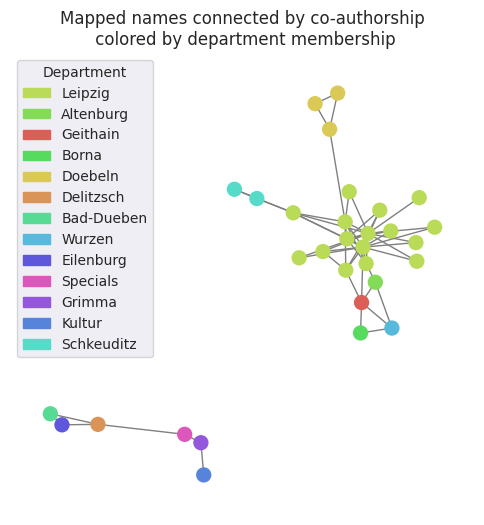

In [33]:
graph = nx.Graph()
graph.clear()

# Count the occurrences of each edge
edge_counts = {}
for edge in edges:
    key = tuple(sorted(edge))
    edge_counts[key] = edge_counts.get(key, 0) + 1

color_map = []

# Add nodes and weighted edges to the graph
for edge, count in edge_counts.items():
    node1, node2 = edge
    if count < 5:
        continue
    if not graph.has_node(node1):
        graph.add_node(node1)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node1].color.values[0])
    if not graph.has_node(node2):
        graph.add_node(node2)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node2].color.values[0])
    graph.add_edge(node1, node2, weight=count)

# display graph
plt.figure(figsize=[6, 6])
plt.title('Mapped names connected by co-authorship\n colored by department membership')
nx.draw(graph, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')
# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
# get department names from author_departments that are in color_map
departments_in_color_map = [author_departments[author_departments.color == color].department.values[0] for color in color_map]
# merge as dict with department name as key and color as value
color_legend_map = dict(zip(departments_in_color_map, color_map))
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_legend_map.items()]
plt.legend(handles=legend_patches, title='Department', loc='upper left')
plt.savefig('../reports/figures/department_exploration/mapped_names_co_authors_department_membership.png', dpi=200)

It looks very similar to the abbreviations figure. That means that the mapping is already quite good and we could further take into account the department membership. 
(We do see a slightly different figure for the abbreviations because the articles we choose to base co-authorship on for this example are different articles because they are those connected to the abbreviations (DIRECT_MATCH, FUZZY_MATCH) and not to the authors (IS_FULL_NAME).

In [ ]:
# TODO 09.08: better uniformly coloring for the ressorts across all figues and notebooks 